In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wind-power-forecasting/Turbine_Data.csv


<h2>Loading libraries/data</h2>

In [2]:
import warnings
warnings.simplefilter(action='ignore')
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot, scatter_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor

The data description reads:

> Here's data of a certain windmill...It contains various weather, turbine and rotor features. Data has been recorded from January 2018 till March 2020. Readings have been recorded at a 10-minute interval.
 

In [3]:
df = pd.read_csv('/kaggle/input/wind-power-forecasting/Turbine_Data.csv', parse_dates=['Unnamed: 0'])
df.head()

,Unnamed: 0,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,...,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
0,2017-12-31 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
1,2017-12-31 00:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2,2017-12-31 00:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
3,2017-12-31 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
4,2017-12-31 00:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN


In [4]:
df = df.rename(columns = {'Unnamed: 0' : 'date'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118224 entries, 0 to 118223
Data columns (total 22 columns):
 #   Column                        Non-Null Count   Dtype              
---  ------                        --------------   -----              
 0   date                          118224 non-null  datetime64[ns, UTC]
 1   ActivePower                   94750 non-null   float64            
 2   AmbientTemperatue             93817 non-null   float64            
 3   BearingShaftTemperature       62518 non-null   float64            
 4   Blade1PitchAngle              41996 non-null   float64            
 5   Blade2PitchAngle              41891 non-null   float64            
 6   Blade3PitchAngle              41891 non-null   float64            
 7   ControlBoxTemperature         62160 non-null   float64            
 8   GearboxBearingTemperature     62540 non-null   float64            
 9   GearboxOilTemperature         62438 non-null   float64            
 10  GeneratorRPM        

<h2>EDA</h2>

In [5]:
df.describe()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
count,94750.000000,93817.000000,62518.000000,41996.000000,41891.000000,41891.000000,62160.0,62540.000000,62438.000000,62295.000000,62427.000000,62449.000000,62406.000000,62507.000000,72278.000000,94748.000000,62127.000000,6.290800e+04,72278.000000,94595.000000
mean,619.109805,28.774654,43.010189,9.749641,10.036535,10.036535,0.0,64.234170,57.561217,1102.026269,72.460403,71.826659,36.897978,39.547603,196.290539,88.133966,9.907500,2.280429e+03,196.290539,5.878960
std,611.275373,4.369145,5.545312,20.644828,20.270465,20.270465,0.0,10.455556,6.323895,528.063946,22.627489,22.650255,5.178711,5.732783,88.296554,116.596725,4.718421,3.586034e+05,88.296554,2.619084
min,-38.524659,0.000000,0.000000,-43.156734,-26.443415,-26.443415,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-203.182591,0.000000,0.000000e+00,0.000000,0.000000
25%,79.642258,25.627428,39.840247,-0.939849,-0.433264,-0.433264,0.0,57.872242,53.942181,1029.812177,55.492241,54.763998,33.943949,35.812500,145.000000,-0.432137,9.231091,2.000000e+00,145.000000,3.823330
50%,402.654893,28.340541,42.910877,0.394399,0.888977,0.888977,0.0,64.834662,57.196089,1124.860720,65.788800,65.004946,37.003815,39.491310,182.000000,35.883659,10.098702,2.000000e+00,182.000000,5.557765
75%,1074.591780,31.664772,47.007976,8.099302,8.480194,8.480194,0.0,71.079306,61.305312,1515.402005,85.867449,85.337740,40.008425,43.359375,271.000000,147.359075,13.600413,2.000000e+00,271.000000,7.506710
max,1779.032433,42.405597,55.088655,90.143610,90.017830,90.017830,0.0,82.237932,70.764581,1809.941700,126.773031,126.043018,47.996185,54.250000,357.000000,403.713620,16.273495,6.574653e+07,357.000000,22.970893


In [6]:
df.nunique().sort_values(ascending=False)

date                            118224
WindSpeed                        94224
ActivePower                      94084
ReactivePower                    94040
AmbientTemperatue                93678
GeneratorWinding2Temperature     62424
GearboxOilTemperature            62412
GeneratorWinding1Temperature     62406
GearboxBearingTemperature        62313
BearingShaftTemperature          62286
GeneratorRPM                     61074
RotorRPM                         59254
MainBoxTemperature               49145
Blade3PitchAngle                 39021
Blade2PitchAngle                 39021
Blade1PitchAngle                 38946
HubTemperature                   38119
NacellePosition                   6664
WindDirection                     6664
TurbineStatus                      353
ControlBoxTemperature                1
WTG                                  1
dtype: int64

The feature 'ControlBoxTemperature' and 'WTG' has just one value, so they have no predictive power and can be dropped (however their information should not be discarded, as the goodness of the model predictions will therefore be guaranteed only in the state these features specify)

In [7]:
df.drop(['ControlBoxTemperature', 'WTG'], axis = 1, inplace=True)

In [8]:
df.TurbineStatus.dropna().value_counts().sort_values(ascending=False)

TurbineStatus
2.0           55073
1.0            2159
3.0            1100
16384.0         782
512.0           286
              ...  
61376732.0        1
7469.0            1
7228.0            1
768.0             1
888.0             1
Name: count, Length: 353, dtype: int64

We look at the latest timestamps:

In [9]:
df.tail()

,date,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
118219,2020-03-30 23:10:00+00:00,70.044465,27.523741,45.711129,1.515669,1.950088,1.950088,59.821165,55.193793,1029.870744,59.060367,58.148777,39.008931,36.476562,178.0,13.775785,9.234004,2.0,178.0,3.533445
118220,2020-03-30 23:20:00+00:00,40.833474,27.602882,45.598573,1.702809,2.136732,2.136732,59.142038,54.798545,1030.160478,58.452003,57.550367,39.006759,36.328125,178.0,8.088928,9.229370,2.0,178.0,3.261231
118221,2020-03-30 23:30:00+00:00,20.777790,27.560925,45.462045,1.706214,2.139664,2.139664,58.439439,54.380456,1030.137822,58.034071,57.099335,39.003815,36.131944,178.0,4.355978,9.236802,2.0,178.0,3.331839
118222,2020-03-30 23:40:00+00:00,62.091039,27.810472,45.343827,1.575352,2.009781,2.009781,58.205413,54.079014,1030.178178,57.795387,56.847239,39.003815,36.007805,190.0,12.018077,9.237374,2.0,190.0,3.284468
118223,2020-03-30 23:50:00+00:00,68.664425,27.915828,45.231610,1.499323,1.933124,1.933124,58.581716,54.080505,1029.834789,57.694813,56.741040,39.003815,35.914062,203.0,14.439669,9.235532,2.0,203.0,3.475205


<h3>Checking for missing/duplicate date</h3>

In [10]:
date_range = pd.date_range(start='2017-12-31 00:00:00+00:00', end = '2020-03-30 23:50:00+00:00', freq = '10min' )
date_missing = date_range[~date_range.isin(df['date'])]

check_missing = len(date_missing) > 0
print('MISSING TIMESTAMPS: ', check_missing)
print(f'{len(date_missing)} timestamps missing:\n{date_missing.values}') if check_missing else print('No missing timestamps.')

date_vc = df['date'].value_counts()
date_duplicates = date_vc[date_vc > 1]
check_duplicates = len(date_duplicates) > 0
print(f'{len(date_duplicates)} timestamps duplicates:\n{date_duplicates.values}') if check_duplicates else print('No duplicates timestamps.')


MISSING TIMESTAMPS:  False
No missing timestamps.
No duplicates timestamps.


<h3>Missing values</h3>

In [11]:
missing_perc = ((100*df.isnull().sum())/len(df)).round(2)
missing_perc.sort_values(ascending=False)

Blade2PitchAngle                64.57
Blade3PitchAngle                64.57
Blade1PitchAngle                64.48
RotorRPM                        47.45
GeneratorRPM                    47.31
HubTemperature                  47.21
GeneratorWinding1Temperature    47.20
GearboxOilTemperature           47.19
GeneratorWinding2Temperature    47.18
MainBoxTemperature              47.13
BearingShaftTemperature         47.12
GearboxBearingTemperature       47.10
TurbineStatus                   46.79
WindDirection                   38.86
NacellePosition                 38.86
AmbientTemperatue               20.64
WindSpeed                       19.99
ReactivePower                   19.86
ActivePower                     19.86
date                             0.00
dtype: float64

The dataset features have high percentages of missing values and there is no much confidence in any method to replace them, therefore we first analyze which features we'd like to keep and working only on that subset:

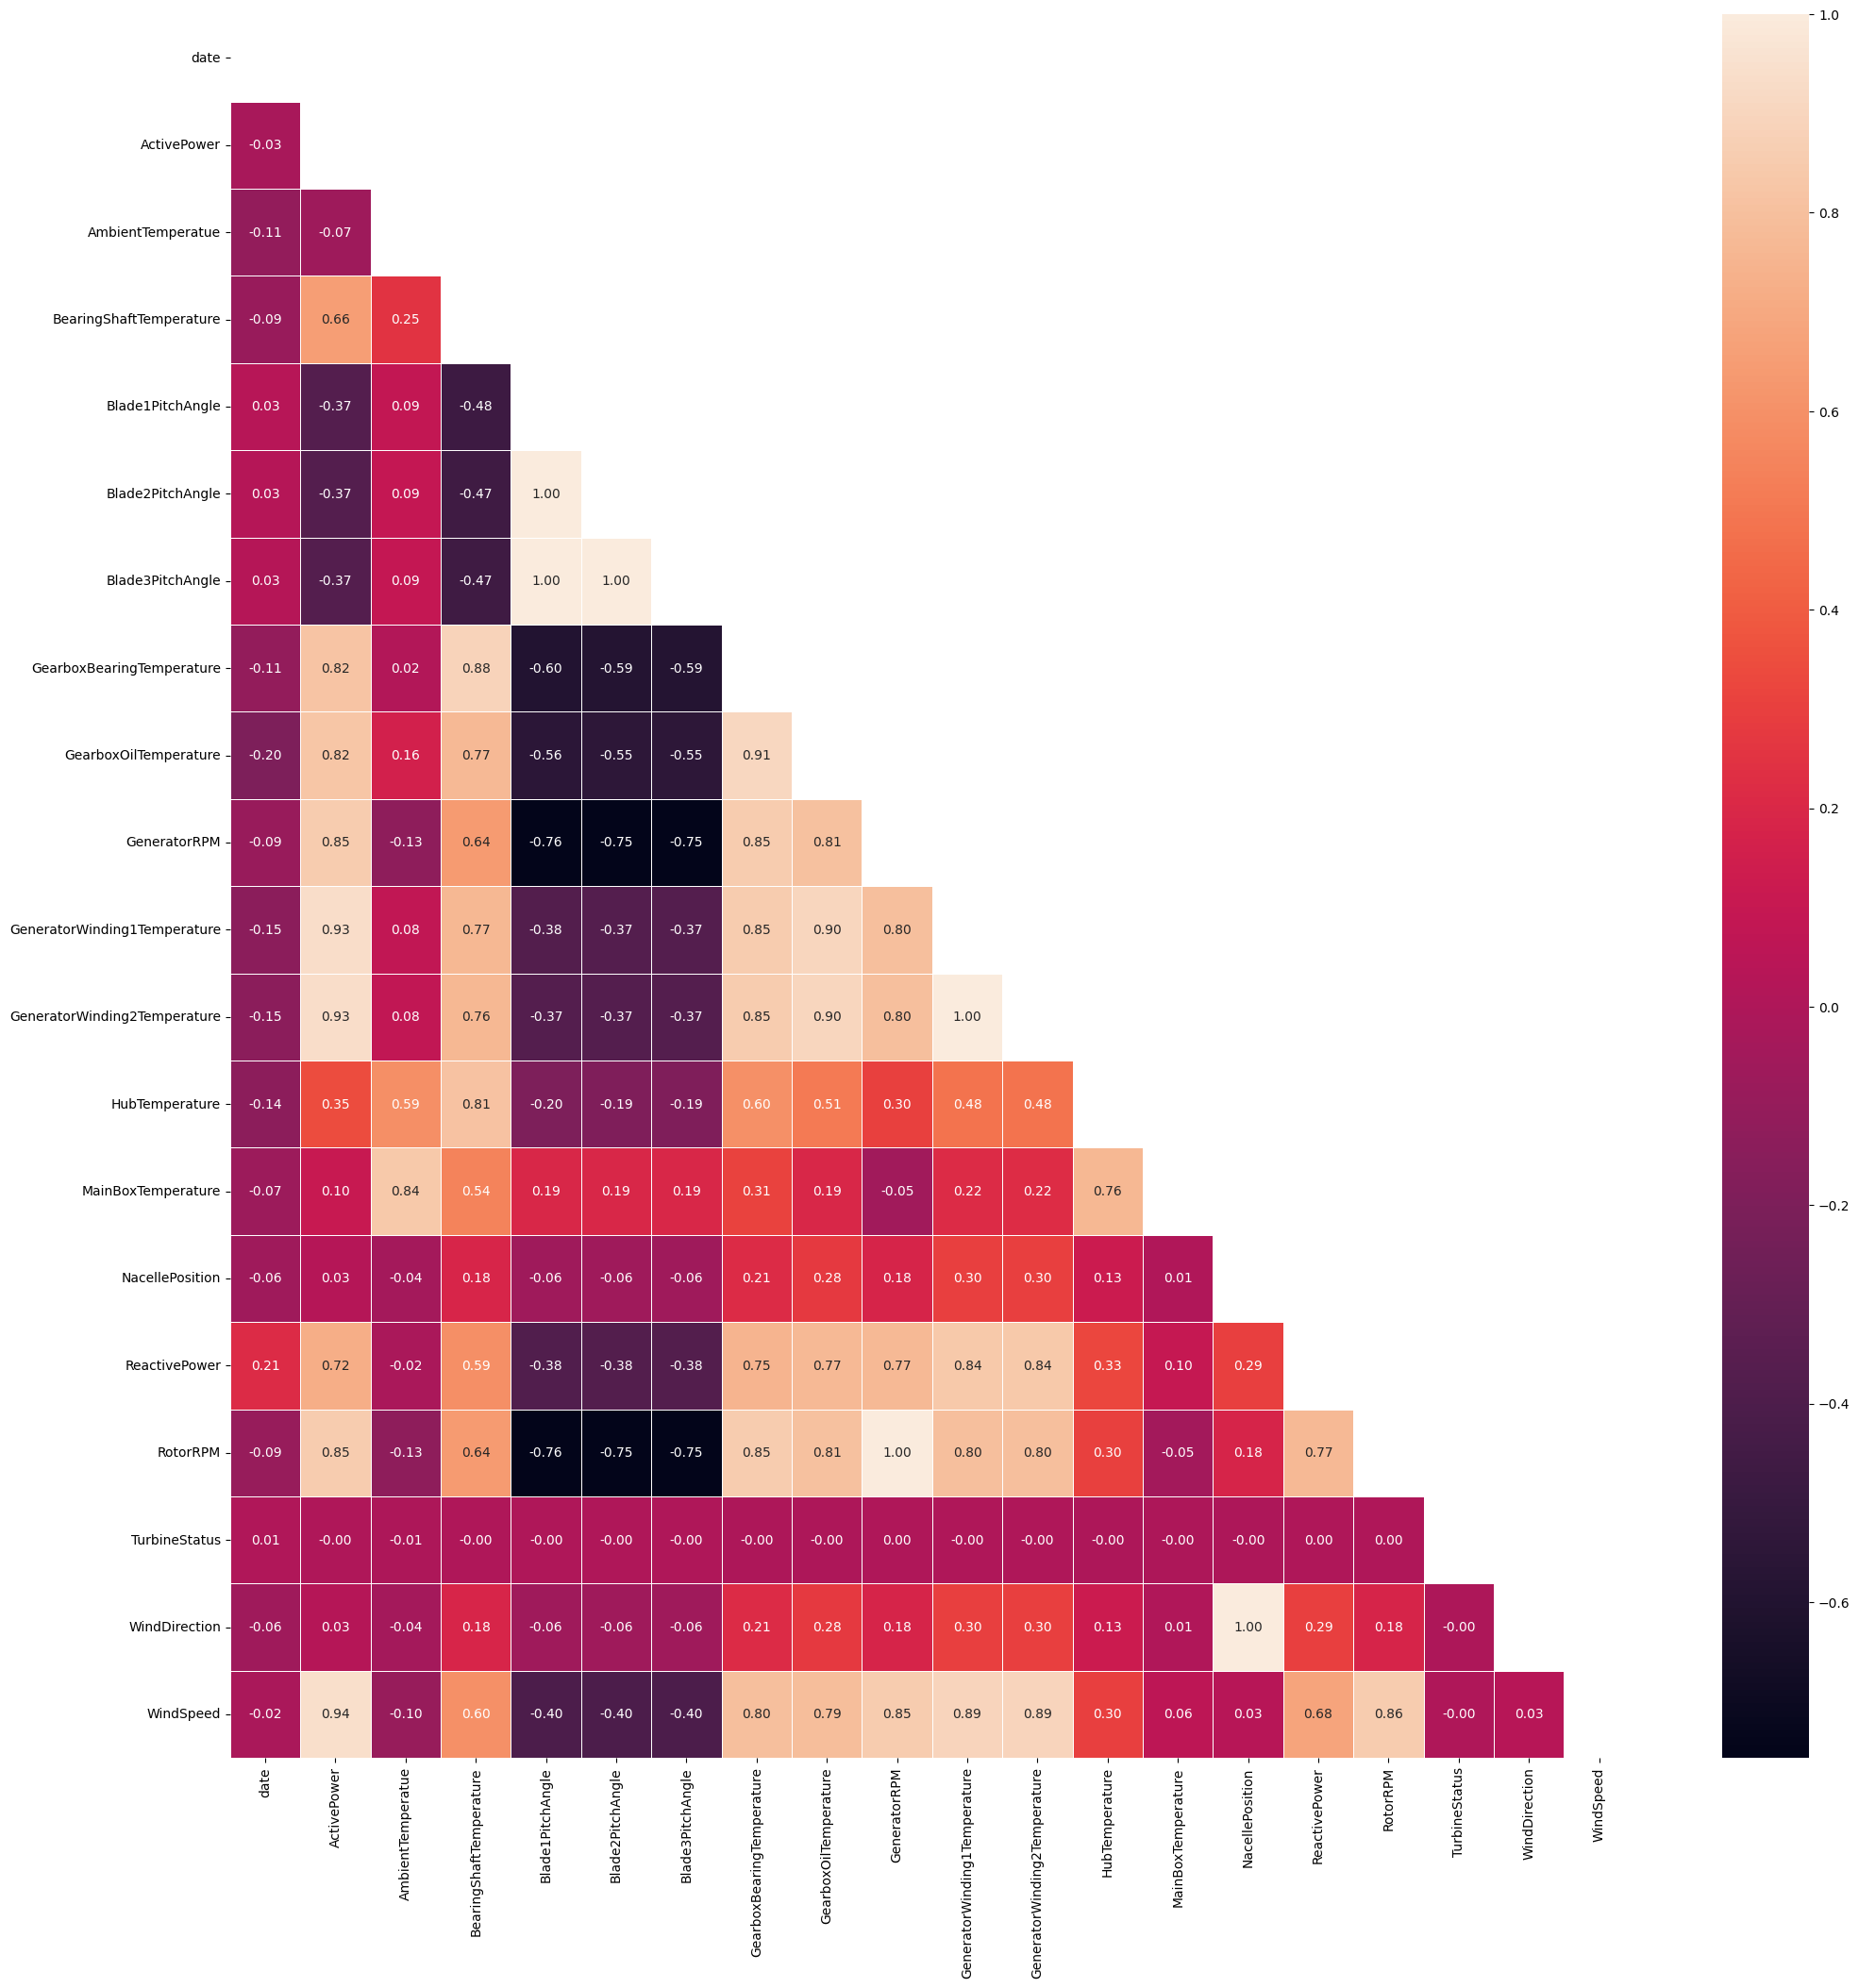

In [12]:
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

_, ax = plt.subplots(figsize=(24,24))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidth=0.5, mask=mask, ax=ax)
plt.show()

A lot of features are correlated with each other and redundant, let's focus on the features relevant to the taget (ActivePower):

In [13]:
corr_matrix['ActivePower'].sort_values(ascending=False)

ActivePower                     1.000000
WindSpeed                       0.940390
GeneratorWinding2Temperature    0.932521
GeneratorWinding1Temperature    0.931390
GeneratorRPM                    0.849604
RotorRPM                        0.849069
GearboxOilTemperature           0.821921
GearboxBearingTemperature       0.818850
ReactivePower                   0.719092
BearingShaftTemperature         0.655400
HubTemperature                  0.347363
MainBoxTemperature              0.101627
NacellePosition                 0.028108
WindDirection                   0.028108
TurbineStatus                  -0.000135
date                           -0.029146
AmbientTemperatue              -0.065637
Blade2PitchAngle               -0.367978
Blade3PitchAngle               -0.367978
Blade1PitchAngle               -0.368997
Name: ActivePower, dtype: float64

Taking only the features with a correlation coefficient > 0.8 the correlation matrix is:

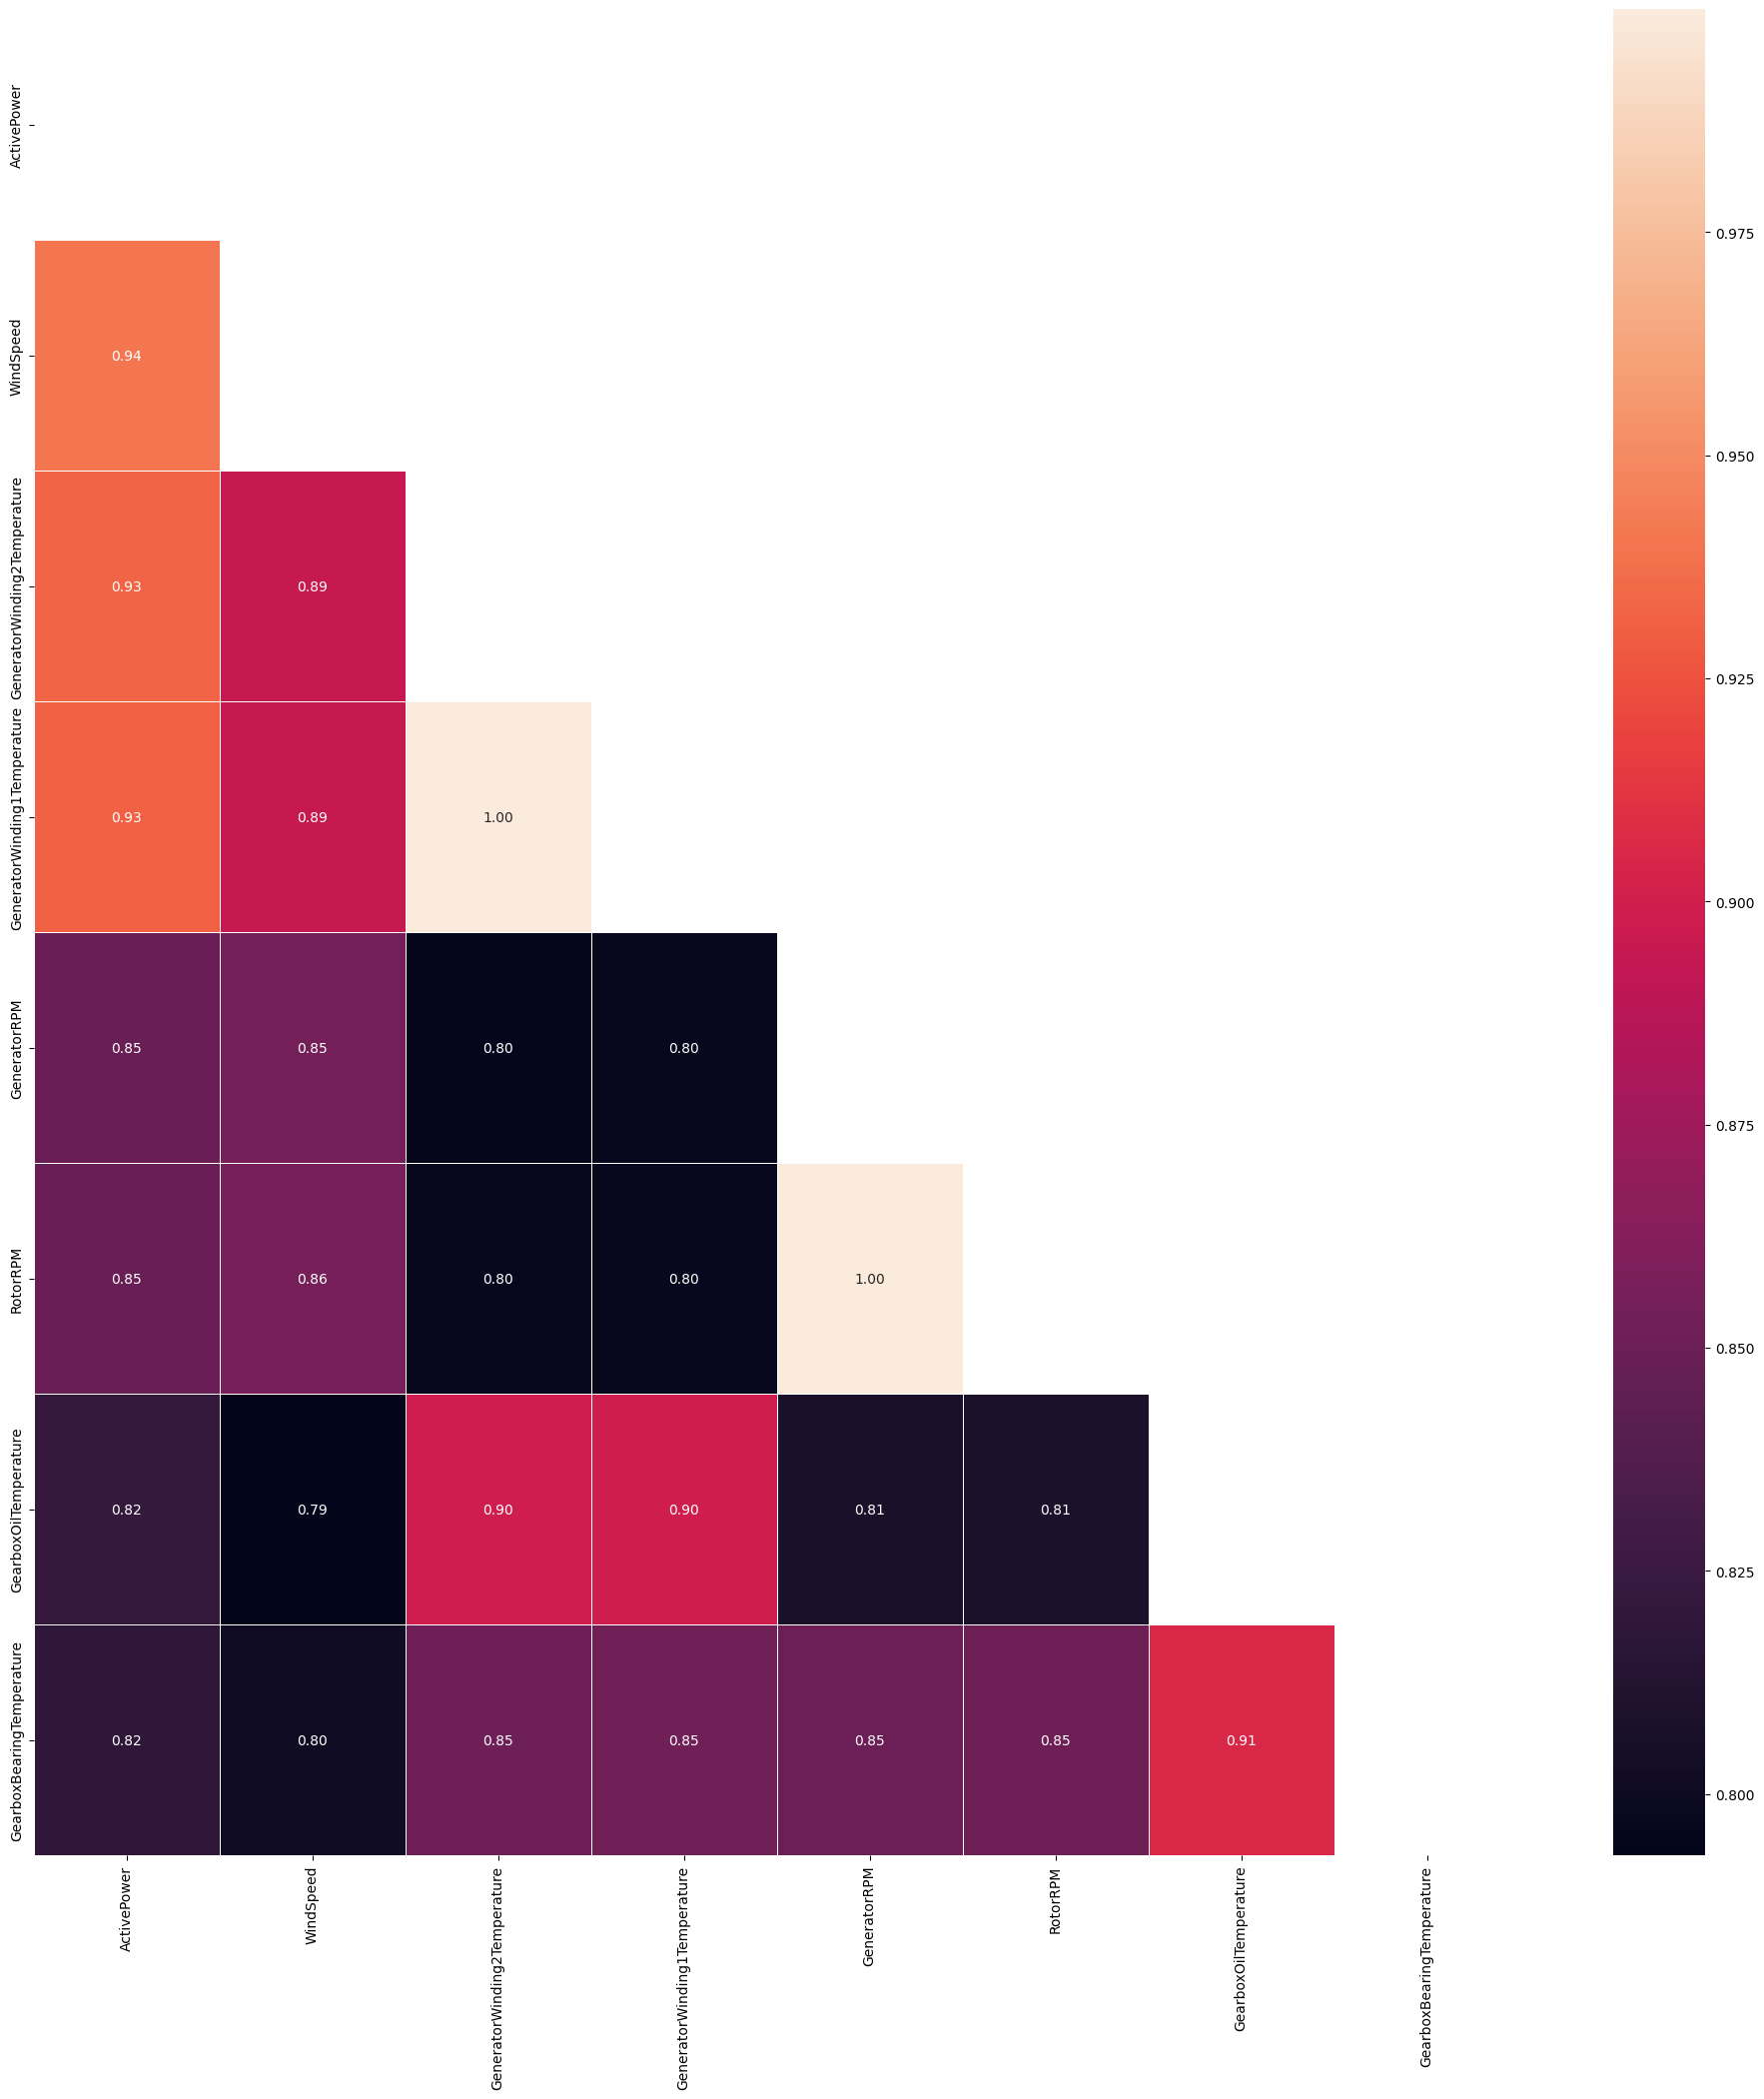

In [14]:
corr_feats = df[['ActivePower', 'WindSpeed', 'GeneratorWinding2Temperature', 'GeneratorWinding1Temperature', 'GeneratorRPM', 'RotorRPM', 'GearboxOilTemperature', 'GearboxBearingTemperature']].corr()
mask_feats = np.triu(np.ones_like(corr_feats, dtype=bool))
_, ax = plt.subplots(figsize=(24,24))
sns.heatmap(corr_feats, annot=True, fmt='.2f', linewidth=0.5, mask=mask_feats, ax=ax)
plt.show()

These feature are still highly correlated and wind speed is the most relevant one (as expected), we take a drastic approach and try to predict with only this feature.

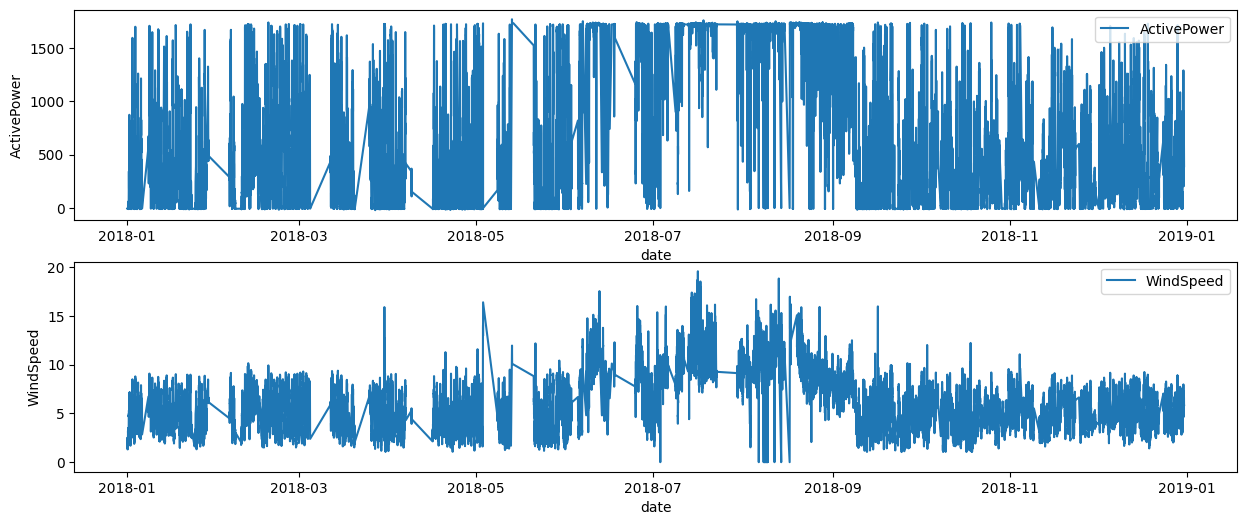

In [15]:
year_sample = df.loc[:6*24*365,:]
_, (ax0, ax1) = plt.subplots(2,1, figsize=(15,6))
sns.lineplot(data = year_sample, x = 'date', y = 'ActivePower', ax = ax0, label = 'ActivePower')
sns.lineplot(data = year_sample, x = 'date', y = 'WindSpeed', ax = ax1, label = 'WindSpeed')
plt.legend()
plt.show()

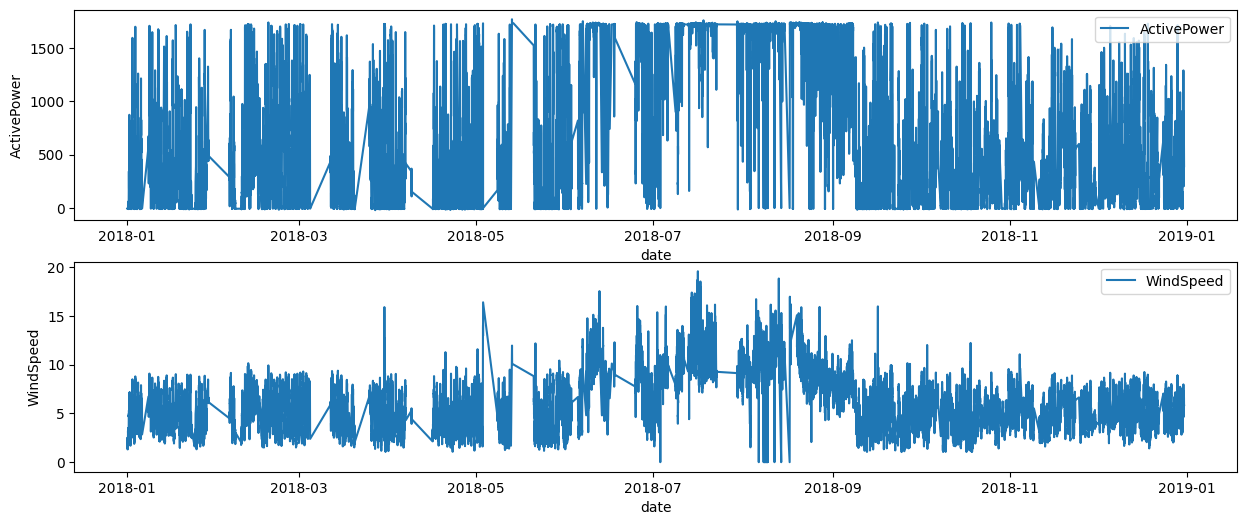

In [16]:
day_sample = df.loc[:6*24,:]
_, (ax0, ax1) = plt.subplots(2,1, figsize=(15,6))
sns.lineplot(data = year_sample, x = 'date', y = 'ActivePower', ax = ax0, label = 'ActivePower')
sns.lineplot(data = year_sample, x = 'date', y = 'WindSpeed', ax = ax1, label = 'WindSpeed')
plt.legend()
plt.show()

We then fill most of missing values with linear interpolation:

In [17]:
df_reduced = df[['date', 'WindSpeed', 'ActivePower']]
df_reduced['WindSpeed'] = df_reduced['WindSpeed'].interpolate(method='linear')
df_reduced['ActivePower'] = df_reduced['ActivePower'].interpolate(method='linear')
df_reduced = df_reduced.set_index('date')
df_reduced.head()

,WindSpeed,ActivePower
date,,
2017-12-31 00:00:00+00:00,NaN,NaN
2017-12-31 00:10:00+00:00,NaN,NaN
2017-12-31 00:20:00+00:00,NaN,NaN
2017-12-31 00:30:00+00:00,NaN,NaN
2017-12-31 00:40:00+00:00,NaN,NaN


In [18]:
missing_perc = ((100*df_reduced.isnull().sum())/len(df)).round(2)
missing_perc.sort_values(ascending=False)

WindSpeed      0.12
ActivePower    0.12
dtype: float64

The remaining missing data are at the beginning of the dataset since linear interpolation lacks a starting point of reference, given their limited number we simply drop them:

In [19]:
df_reduced.dropna(axis=0, inplace=True)
df_reduced.head()

,WindSpeed,ActivePower
date,,
2018-01-01 00:00:00+00:00,2.279088,-5.357727
2018-01-01 00:10:00+00:00,2.339343,-5.822360
2018-01-01 00:20:00+00:00,2.455610,-5.279409
2018-01-01 00:30:00+00:00,2.026754,-4.648054
2018-01-01 00:40:00+00:00,1.831420,-4.684632


We divide the data in a train and test dataset, the latter comprisig 15 days worth of data:

In [20]:
TEST_SIZE = 6*24*15
train, test = df_reduced[:-TEST_SIZE], df_reduced[-TEST_SIZE :]

<h3>Check Stationarity</h3>

We perform the Augmented Dickey Fuller test to check for unit roots:

In [21]:
adf_df = pd.DataFrame()

for cname in train.columns:
    results = adfuller(train[cname])
    adf_df = pd.concat([adf_df, pd.DataFrame({'ADF' : results[0], 'p-value' : results[1], 'Critival values' : str(results[4])}, index=[cname])], axis=0)

adf_df

,ADF,p-value,Critival values
WindSpeed,-17.860481,3.054689e-30,"{'1%': -3.4304064484920125, '5%': -2.861564949..."
ActivePower,-17.105438,7.427450e-30,"{'1%': -3.4304064484920125, '5%': -2.861564949..."


Since p << 0.05 we reject the null hypotesis and conclude that the series are stationary.
We now check for autocorrelation for different lag values:

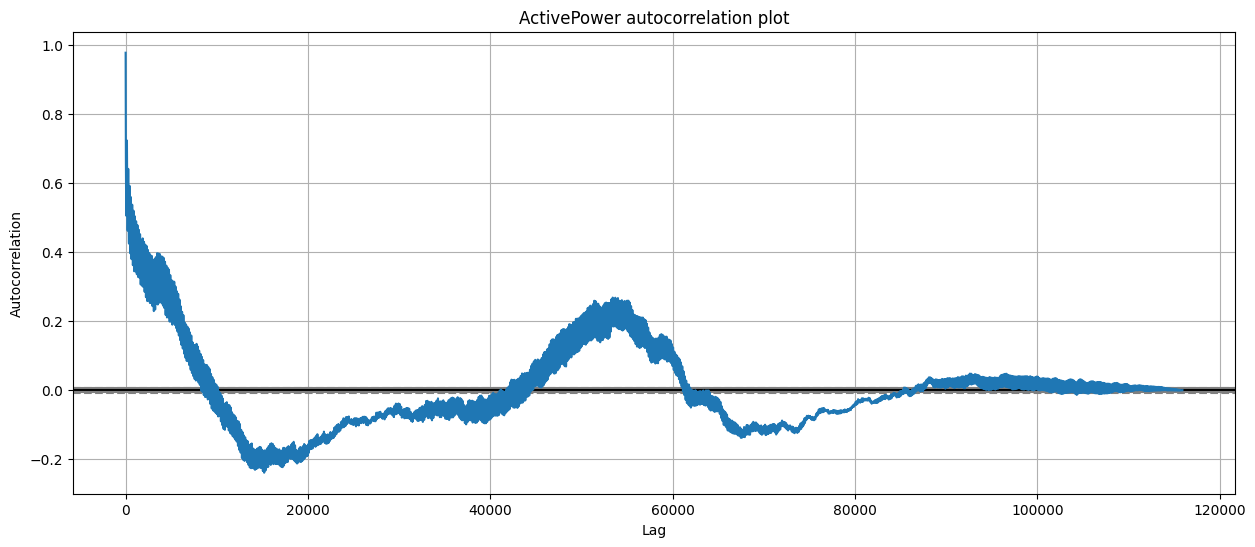

In [22]:
_, ax = plt.subplots(figsize=(15,6))
autocorrelation_plot(train['ActivePower'], ax=ax)
ax.set_title('ActivePower autocorrelation plot')
plt.show()

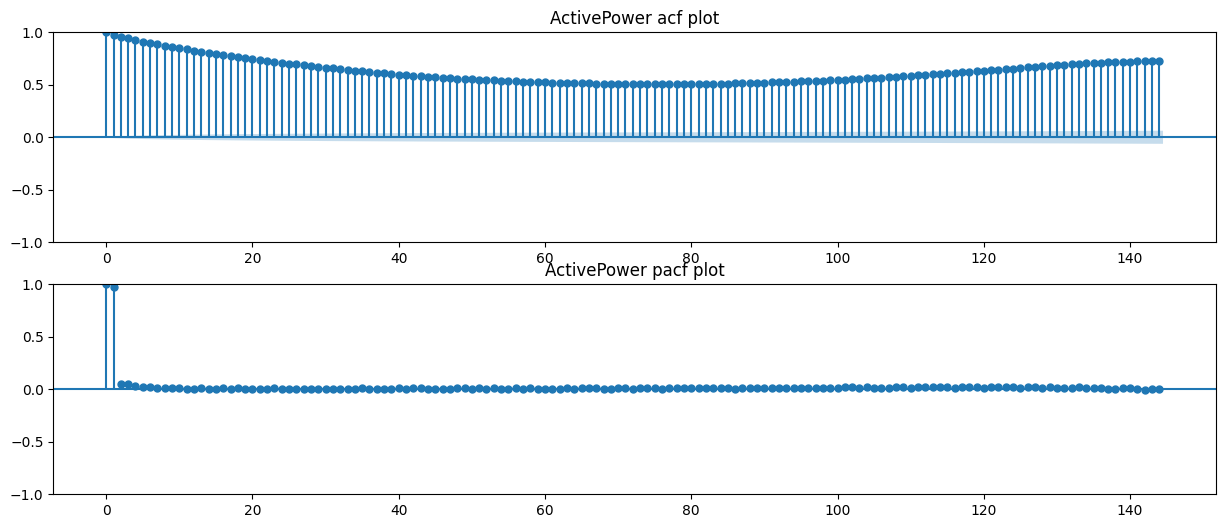

In [23]:
_, (ax0, ax1) = plt.subplots(2,1, figsize=(15,6))
plot_acf(train['ActivePower'], lags = 6*24, ax=ax0)
ax0.set_title('ActivePower acf plot')
plot_pacf(train['ActivePower'], lags = 6*24 , ax=ax1)
ax1.set_title('ActivePower pacf plot')
plt.show()

The autocorrelation function plot shows a strong autoregressive component, however the partial autocorrelation function shows that indipendent autocorrelation is relevant only at lag 1.

<h2>ARIMA Model</h2>

We perform a first fit of the data with an ARIMA model:
<ul>
    <li>The stationarity of the series suggests d = 0 (we'll check for d={0,1}.</li>
    <li>The PACF plot suggests p <=1.</li>
    <li>The ACF plot does not really impose a limit on the q parameter, we'll check for a generic set of values (=[7, 14, 21, 28])</li>
</ul>

In [24]:
def evaluate_arima(train, test, p_vals, d_vals, q_vals):
    best_mse, best_cfg = float('inf'), None
    for p in p_vals:
        for d in d_vals:
            for q in q_vals:
                order = (p, d, q)
                try:
                    model = ARIMA(endog=train.values, order=order)
                    model_fit = model.fit()
                    predictions = model_fit.forecast(steps=len(test))
                    mse = np.sqrt(mean_squared_error(predictions, test))
                    print(f'order: {order} - MSE: {mse}')
                    if mse < best_mse:
                        best_mse = mse
                        best_cfg = order
                except:
                    print(f'fit at order {order} failed')
    print(f'Best configuration: {best_cfg}\nBest mse: {best_mse}')

In [25]:
pdq_dict = {'p_vals' : range(2), 'd_vals' : [0], 'q_vals' : [7, 14, 21, 28]}
#evaluate_arima(train['ActivePower'], test['ActivePower'], **pdq_dict)

<h2>XGBRegressor</h2>

Another quick-to-deploy model is the XGBRegressor; we perform a grid search for different hyperparameters and use the best estimator:

In [26]:
param_grid = {
    'n_estimators' : [100, 200, 300],
    'max_depth' : [5, 7, 9],
    'learning_rate' : [1e-2, 1e-1, 0.3],
    'alpha': [0., 0.1, 1.]
}

X_train, y_train = train[['WindSpeed']], train['ActivePower']
GSCV = GridSearchCV(estimator=XGBRegressor(), param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
GSCV.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'alpha': [0.0, 0.1, 1.0],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [5, 7, 9],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_error', verbose=1)

In [27]:
print('Best score: ', GSCV.best_score_)
print('Best params: ', GSCV.best_params_)

Best score:  -77.24699762953551
Best params:  {'alpha': 0.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


In [28]:
best_model = GSCV.best_estimator_
X_test, y_test = test[['WindSpeed']], test['ActivePower']
xgb_predictions = best_model.predict(X_test)
print('SCORES:\n')
print('Mean absolute error: ', mean_absolute_error(xgb_predictions, y_test))
print('Mean squared error: ', mean_squared_error(xgb_predictions, y_test))
print('Root mean squared error: ', np.sqrt(mean_squared_error(xgb_predictions, y_test)))
print('Mean absolute percentage error: ', mean_absolute_percentage_error(xgb_predictions, y_test))

SCORES:

Mean absolute error:  55.71617857263196
Mean squared error:  8429.122839188582
Root mean squared error:  91.81025454266305
Mean absolute percentage error:  3.7984015351315867


The root mean squared error shows a significant improvement over the crude ARIMA model, the plot on the prediction shown below demonstrate the validity of the fit:

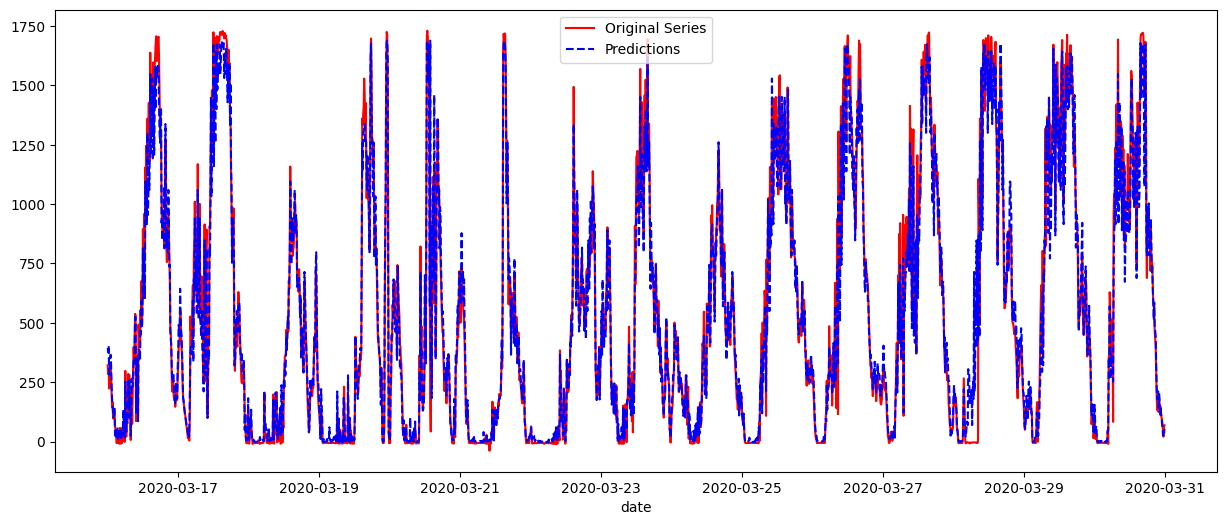

In [29]:
_, ax = plt.subplots(figsize=(15,6))
sns.lineplot(x=test.index, y = test['ActivePower'].values, ax=ax, color='red', label='Original Series')
sns.lineplot(x=test.index, y = xgb_predictions, ax=ax, color='blue', label='Predictions', linestyle='dashed')
plt.show()